In [1]:
import random
import numpy as np
import pandas as pd
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from time import clock

# Assumptions
## 8 nurses, 4 doctors at any given time, around 20 patients/hour, 30 minutes as mean time spent with a nurse/doctor, following normal distribution

In [2]:
nurse = 8
doctor = 4
patient_per_hour = 20  # the range of patients to get a specific patient number would be 18-22

mean_time = 30
sd = 1
min_time = 20
max_time = 40


class TimeDistribution:
    
    def __init__(self, mean_t=0, sd=0, min_t=0, max_t=0, num=0):
        self.mean = mean_t
        self.sd = sd
        self.min = min_t
        self.max = max_t
        self.num = num

    # Return a list of time following normal distribution
    def time_spend(self) -> list:
        generator = truncnorm((self.min-self.mean)/self.sd, (self.max-self.mean)/self.sd, loc=self.mean, scale=self.sd)
        time = generator.rvs(self.num)
        return time

    # Return the sum of the list of time
    def sum_truncnorm(self) -> float:
        generator = truncnorm((self.min - self.mean) / self.sd, (self.max - self.mean) / self.sd, loc=self.mean, scale=self.sd)
        time = generator.rvs(self.num)
        return sum(time)

# Nurse and doctor utilization
## Build the function calculating the utilization of the nurses and doctors in one hour, run it multiple times, put the results in two lists

In [3]:
def utilization(mean_t, sd, min_t, max_t, nurse: int, doctor: int, patient: int, patient_both: int):

    # Calculate the total time (minutes) nurses and doctors need to work with patients in one hour
    total_nurse_time = TimeDistribution(mean_t, sd, min_t, max_t, patient).sum_truncnorm()
    total_doctor_time = TimeDistribution(mean_t, sd, min_t, max_t, patient_both).sum_truncnorm()

    # Calculate the utilization values to return
    utilization_nurse = total_nurse_time / (nurse * 60)
    utilization_doctor = total_doctor_time / (doctor * 60)

    return utilization_nurse, utilization_doctor

ut_nurse, ut_doctor = [], []
for i in range(20000):
    
    patient = random.randint(18, 22)
    patient_nurse_doctor = int(patient * 0.8)
    
    utilization_nurse, utilization_doctor = utilization(mean_time, sd, min_time, max_time, nurse, doctor, patient, patient_nurse_doctor)
    ut_nurse.append(utilization_nurse)
    ut_doctor.append(utilization_doctor)

## Show the plot of the list of nurse utilization rates: in 20000 simulations, the rates mostly remains between 1.12 to 1.38

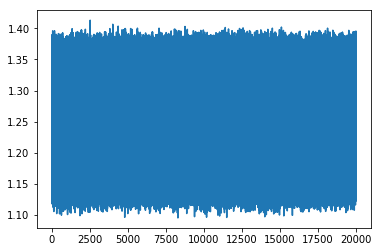

In [4]:
plt.plot(ut_nurse)
plt.show()

## Show the plot of the list of doctor utilization values: in 20000 simulations, the rates mostly remains between 1.75 to 2.15

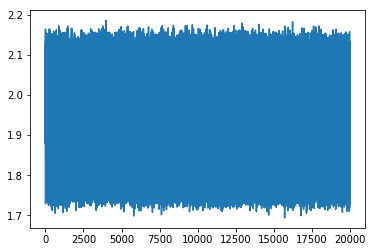

In [5]:
plt.plot(ut_doctor)
plt.show()

# Patients waiting time
## Build a function calculating the average and max waiting time for a nurse and a doctor of a patient

In [6]:
def wait_time(mean_t, sd, min_t, max_t, nurse, doctor, patient, patient_nurse, patient_both):
    
    """Create a dataframe with a list of patient as index, storing the time point data and time spent length data of 
       each patient"""
    # Create a list of patient as [patient_1, patient_2, ..., patient_totalnumberofpatients], in order
    list_patient = []
    for i in range(patient):
        list_patient.append('patient_{}'.format(i+1))

    # The list of data as index, all initial time data as 0, and assume all patients to see both a nurse and a doctor
    df_patients = pd.DataFrame({'Arrival_point': 0, 'Nurse_only': False,
                                'Waiting_nurse': 0, 'Meet_nurse_point': 0,
                                'Seeing_nurse': 0, 'After_nurse_point': 0,
                                'Waiting_doctor': 0, 'Meet_doctor_point': 0,
                                'Seeing_doctor': 0, 'After_doctor_point': 0}, index=list_patient)

    """Deal with 'Arrival_point', 'Nurse_only', 'Seeing_nurse' columns"""
    # Create a list of random numbers that sum to 60 as gaps between every two patients, get patient arrival point
    total_time = 60
    random_arrival = [random.random() for i in range(patient)]
    sum_arrival = sum(random_arrival)
    arrival_time = [total_time * i / sum_arrival for i in random_arrival]
    for i in range(patient):
        df_patients.loc[list_patient[i], 'Arrival_point'] += sum(arrival_time[:i])

    # Randomly select certain number of patients as people only come to see a nurse
    list_patient_nurse_num = random.sample(list(range(patient)), patient_nurse)
    for i in list_patient_nurse_num:
        df_patients.loc['patient_{}'.format(i + 1), 'Nurse_only'] = True

    # Randomly get the list of time patients spending with nurses
    df_patients['Seeing_nurse'] = TimeDistribution(mean_t, sd, min_t, max_t, patient).time_spend()

    """Create two nurse and doctor arrays, deal with 'Meet_nurse_point', 'Waiting_nurse', 'After_nurse_point' columns, 
       update nurse array"""
    # Create two arrays for nurses and doctors, each item represents the available time point of a nurse or a doctor
    arr_nurse = np.zeros(nurse)
    arr_doctor = np.zeros(doctor)

    for i in range(patient):
        # Compare the min value in nurse array and the arrival point of each patient to get'Meet_nurse_point'
        if min(arr_nurse) <= df_patients.loc[list_patient[i], 'Arrival_point']:
            df_patients.loc[list_patient[i], 'Meet_nurse_point'] = df_patients.loc[list_patient[i], 'Arrival_point']
        else:
            df_patients.loc[list_patient[i], 'Meet_nurse_point'] = min(arr_nurse)

        df_patients.loc[list_patient[i], 'Waiting_nurse'] = df_patients.loc[list_patient[i], 'Meet_nurse_point'] - df_patients.loc[list_patient[i], 'Arrival_point']
        df_patients.loc[list_patient[i], 'After_nurse_point'] = df_patients.loc[list_patient[i], 'Meet_nurse_point'] + df_patients.loc[list_patient[i], 'Seeing_nurse']

        # Update the value of the nurse in the array, store his/her next available point in the array
        arr_nurse[np.argmin(arr_nurse)] += df_patients.loc[list_patient[i], 'Seeing_nurse']

        
    """Deal with 'Meet_doctor_point', 'Waiting_doctor', 'Seeing_doctor', 'After_nurse_point' columns, update doctor 
       array during iterating, similar to nurse columns"""
    # Select patients only to see a nurse, put None to their doctor-related cells
    list_patient_nurse = [p for p in df_patients[df_patients['Nurse_only'] == True].index]
    for i in range(patient_nurse):
        df_patients.loc[list_patient_nurse[i], 'Waiting_doctor':'After_doctor_point'] = None

    # Randomly put time periods to the 'See_doctor' cells of people to see a doctor
    list_patient_both = [p for p in df_patients[df_patients['Nurse_only'] == False].index]
    time_doctor = TimeDistribution(mean_t, sd, min_t, max_t, patient_both).time_spend()
    for i in range(patient_both):
        df_patients.loc[list_patient_both[i], 'Seeing_doctor'] = time_doctor[i]

    for i in range(patient_both):
        # Compare the min value in doctor array and the After_nurse_point of each patient, get 'Meet_doctor_point'
        if min(arr_doctor) <= df_patients.loc[list_patient_both[i], 'After_nurse_point']:
            df_patients.loc[list_patient_both[i], 'Meet_doctor_point'] = df_patients.loc[list_patient_both[i], 'After_nurse_point']
        else:
            df_patients.loc[list_patient_both[i], 'Meet_doctor_point'] = min(arr_doctor)

        df_patients.loc[list_patient_both[i], 'Waiting_doctor'] = df_patients.loc[list_patient_both[i], 'Meet_doctor_point'] - df_patients.loc[list_patient_both[i], 'After_nurse_point']
        df_patients.loc[list_patient_both[i], 'After_doctor_point'] = df_patients.loc[list_patient_both[i], 'Meet_doctor_point'] + df_patients.loc[list_patient_both[i], 'Seeing_doctor']

        # Update the value of the doctor in the array, store his/her next available point in the array
        arr_doctor[np.argmin(arr_doctor)] += df_patients.loc[list_patient_both[i], 'Seeing_doctor']

    """After building the dataframs, get the average and max values of Waiting_nurse and Wating_doctor columns to return"""
    average_wait_nurse = round(df_patients['Waiting_nurse'].mean(), 2)
    max_wait_nurse = round(df_patients['Waiting_nurse'].max(), 2)
    average_wait_doctor = round(df_patients['Waiting_doctor'].sum() / patient_both, 2)
    max_wait_doctor = round(df_patients['Waiting_doctor'].max(), 2)

    return average_wait_nurse, max_wait_nurse, average_wait_doctor, max_wait_doctor, df_patients

## Show one example of the dataframe built in this process

In [9]:
patient = random.randint(18, 22)
patient_nurse_doctor = int(patient * 0.8)
patient_nurse = patient - patient_nurse_doctor

wait_time(mean_time, sd, min_time, max_time, nurse, doctor, patient, patient_nurse, patient_nurse_doctor)[-1]

,Arrival_point,Nurse_only,Waiting_nurse,Meet_nurse_point,Seeing_nurse,After_nurse_point,Waiting_doctor,Meet_doctor_point,Seeing_doctor,After_doctor_point
patient_1,0.000000,False,0.000000,0.000000,30.175891,30.175891,0.000000,30.175891,28.756844,58.932735
patient_2,3.115644,False,0.000000,3.115644,31.486015,34.601659,0.000000,34.601659,29.110017,63.711676
patient_3,7.235595,True,0.000000,7.235595,30.817487,38.053082,NaN,NaN,NaN,NaN
patient_4,8.338012,False,0.000000,8.338012,29.631160,37.969172,0.000000,37.969172,30.799787,68.768960
patient_5,8.418766,False,0.000000,8.418766,30.383003,38.801769,0.000000,38.801769,32.100078,70.901846
patient_6,11.911356,False,0.000000,11.911356,31.442721,43.354077,0.000000,43.354077,31.685525,75.039602
patient_7,14.001435,True,0.000000,14.001435,28.932021,42.933456,NaN,NaN,NaN,NaN
patient_8,15.476225,False,0.000000,15.476225,30.215435,45.691660,0.000000,45.691660,30.048820,75.740480
patient_9,19.231828,True,9.700192,28.932021,27.982293,56.914314,NaN,NaN,NaN,NaN
patient_10,19.270848,False,10.360312,29.631160,31.505165,61.136325,0.000000,61.136325,30.868509,92.004835


## Run the wait_time function multiple times, put the results from each running in several lists

In [10]:
ave_nurse, max_nurse, ave_doctor, max_doctor = [], [], [], []
for i in range(20000):
    patient = random.randint(18, 22)
    patient_nurse_doctor = int(patient * 0.8)
    patient_nurse = patient - patient_nurse_doctor
    
    ave_n, max_n, ave_d, max_d = wait_time(mean_time, sd, min_time, max_time, nurse, doctor, patient, patient_nurse, patient_nurse_doctor)[:4]
    ave_nurse.append(ave_n)
    max_nurse.append(max_n)
    ave_doctor.append(ave_d)
    max_doctor.append(max_d)

## Show the plot of the list of average waiting time for a nurse: in 20000 simulations, it mostly remains between 0 to 5 minutes

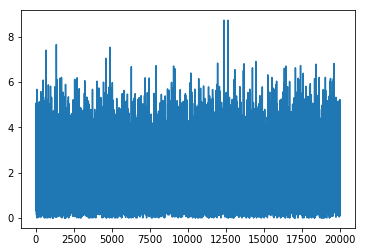

In [11]:
plt.plot(ave_nurse)
plt.show()

## Show the plot of the list of maximum waiting time for a nurse: in 20000 simulations, it mostly remains between 2 to 20 minutes

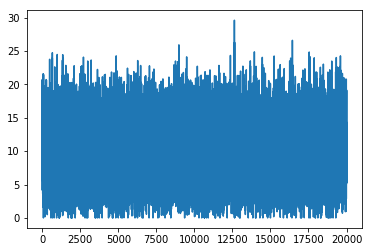

In [12]:
plt.plot(max_nurse)
plt.show()

## Show the plot of the list of average waiting time for a doctor: in 20000 simulations, it mostly remains between 0 to 4 minutes

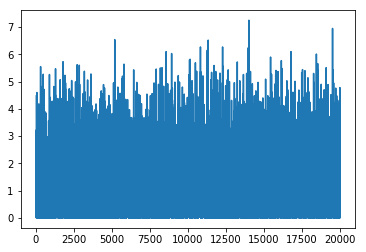

In [13]:
plt.plot(ave_doctor)
plt.show()

## Show the plot of the list of maximum waiting time for a doctor: in 20000 simulations, it mostly remains between 0 to 30 minutes

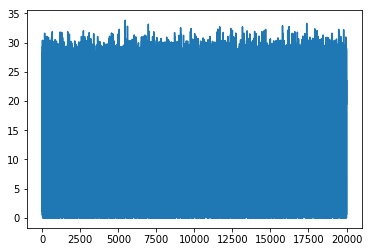

In [14]:
plt.plot(max_doctor)
plt.show()